In [10]:
import matplotlib as mpl
import pandas as pd
import numpy as np
import scanpy as sc
import seaborn as sns
from scipy.stats import median_abs_deviation

# Data read-in

In [2]:
# scanpy h5ad route
adata = sc.read_h5ad('adata.h5ad')

# Calculate QC matrices

In [7]:
adata.var["mt"] = adata.var_names.str.startswith("MT-")
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))

sc.pp.calculate_qc_metrics(
    adata, qc_vars = ["mt", "ribo", "hb"], inplace = True, percent_top = [20], log1p = True
)

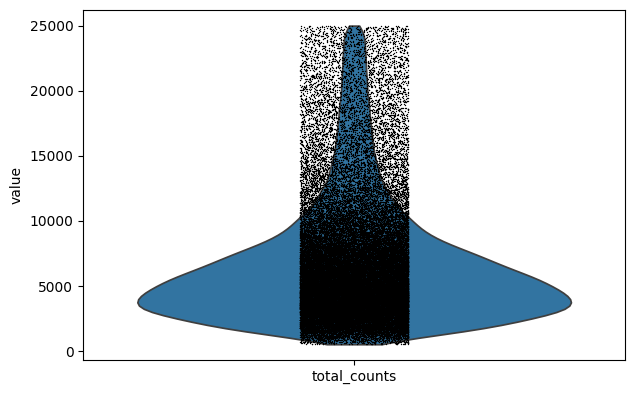

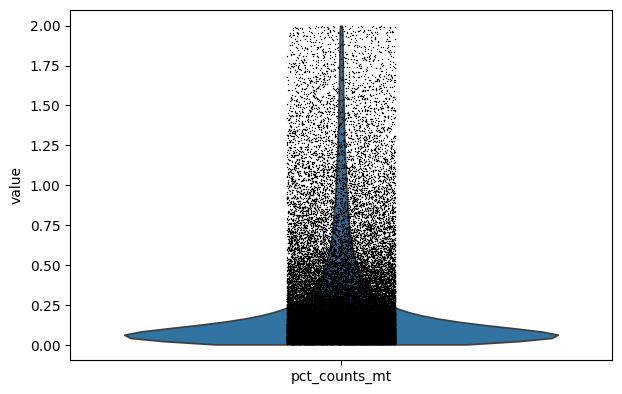

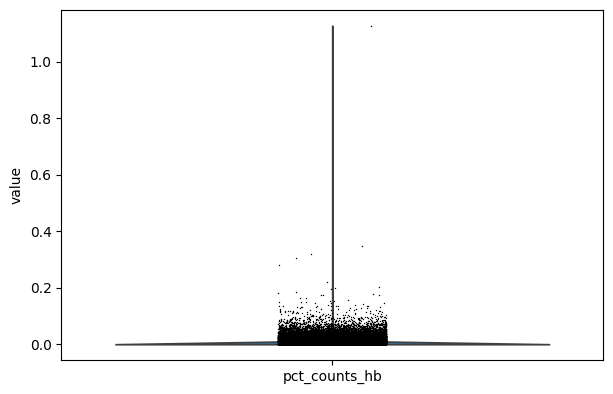

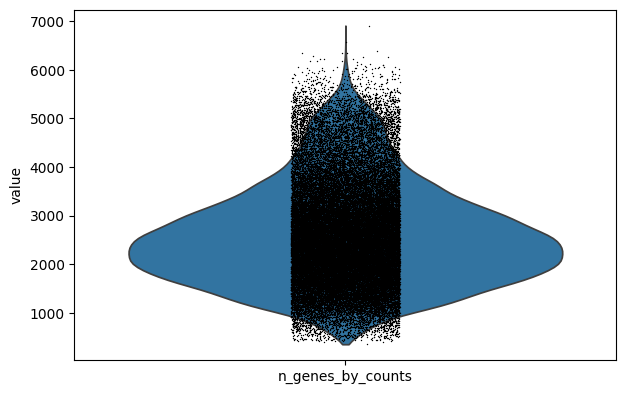

In [8]:
sc.pl.violin(adata, 'total_counts')
sc.pl.violin(adata, "pct_counts_mt")
sc.pl.violin(adata, "pct_counts_hb")
sc.pl.violin(adata, "n_genes_by_counts")

In [4]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

In [28]:
adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
    | (adata.obs["n_genes_by_counts"] > 5000)
    | (adata.obs["n_genes_by_counts"] < 500)
)
adata.obs.outlier.value_counts()

outlier
False    6781
True      495
Name: count, dtype: int64

In [29]:
adata.obs["mt_outlier"] = (
    adata.obs["pct_counts_mt"] > 20
)
adata.obs.mt_outlier.value_counts()

mt_outlier
False    7218
True       58
Name: count, dtype: int64

In [30]:
print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 7276
Number of cells after filtering of low quality cells: 6781


In [10]:
adata.obs[['Group', 'group', 'Subject', 'cellType', 'cellType2', 'subcluster']]

,Group,group,Subject,cellType,cellType2,subcluster
AAACCCAAGCCTTGAT-1,HEALTHY,CTRL,CL0412,vEDO,vEDO,arterialEC1
AAACCCAAGTTGGCTT-1,HEALTHY,CTRL,CL0412,vEDO,vEDO,capEC1
AAACCCACAGAGGGTT-1,HEALTHY,CTRL,CL0412,CM,CM,CM2
AAACCCACATGGCACC-1,HEALTHY,CTRL,CL0412,CM,CM,CM1
AAACCCAGTGCGAGTA-1,HEALTHY,CTRL,CL0412,CM,CM,CM1
...,...,...,...,...,...,...
TTTGTTGGTATGAGGC-13,HCM,CASE,HCM823,Peri,Peri,pericyte1
TTTGTTGGTCCAAAGG-13,HCM,CASE,HCM823,Peri,Peri,pericyte3
TTTGTTGGTTCAGGTT-13,HCM,CASE,HCM823,vEDO,vEDO,venousEC
TTTGTTGTCAACGTGT-13,HCM,CASE,HCM823,Peri,Peri,pericyte1
